First we need to import the useful libraries and load the data that we have previously prepared.

In [14]:
import os
import h5py
import csv
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

We also need to define a few functions useful for showing the final results.

In [16]:
def smooth_curve(points,factor=0.9):
    smoothed_points=[]
    for point in points:
        if smoothed_points:
            previous=smoothed_points[-1]
            smoothed_points.append(previous*factor+point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


def residual_plot(y_true_train,y_pred_train,y_true_val,y_pred_val,directory,
                  test=False):
    title='Residual_plot'
    plt.figure(title,figsize=(10,10))
    diff_train=y_pred_train-y_true_train
    #Train and validation data
    if test==False:
        plt.scatter(y_pred_train,diff_train,c='blue',label='Train data', alpha=0.25)
        diff_val=y_pred_val-y_true_val
        plt.scatter(y_pred_val,diff_val,c='green',label='Validation data')
    #Test data
    else:
        plt.scatter(y_pred_train,diff_train,c='green',label='Test data')
        
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0,xmin=min(y_pred_train),xmax=max(y_pred_train),lw=2,color='red')
    file=os.path.join(directory,title+'.png')
    plt.savefig(file)
    plt.show()
    
    
def plot_regression(y_true_train,y_pred_train,y_true_val,y_pred_val,directory,
                    test=False):
    title='Real and predicted values'
    plt.figure(title,figsize=(10,10))
    #Train and validation data
    if test==False:
        plt.scatter(y_true_train,y_pred_train,c='blue',marker='o',
                    label='Train data',alpha=0.25)
        plt.scatter(y_true_val,y_pred_val,c='green',marker='x',
                    label='Validation data')
        r2_train=r2_score(y_true_train,y_pred_train)
        r2_val=r2_score(y_true_val,y_pred_val)
        plt.text(int(0.9*max(y_pred_val)),min(y_true_val),
             'R2_score_val = '+str(round(r2_val,3))+
             '\nR2_score_train = '+str(round(r2_train,3)),
             color='red')
    #Test data
    else:
        plt.scatter(y_true_train,y_pred_train,c='green',marker='x',
                    label='Test data')
        r2_test=r2_score(y_true_train,y_pred_train)
        plt.text(int(0.9*max(y_pred_train)),min(y_true_train),
             'R2_score_test = '+str(round(r2_test,3)),
             color='red')
    
    plt.xlabel('Predicted values (yield)')
    plt.ylabel('Real values (yield)')
    plt.legend(loc='upper left')
    file=os.path.join(directory,title+'.png')
    plt.savefig(file)
    plt.show()
    

def plot_average_losses(history_list,directory, bias=0):
    
    all_val_loss=[]
    all_val_mean_absolute_error=[]
    all_loss=[]
    all_mean_absolute_error=[]
    for hst in history_list:
        val_loss=hst.history['val_loss']
        all_val_loss.append(val_loss)
        
        val_mean_absolute_error=hst.history['val_mae']
        all_val_mean_absolute_error.append(val_mean_absolute_error)
        
        loss=hst.history['loss']
        all_loss.append(loss)
        
        mean_absolute_error=hst.history['mae']
        all_mean_absolute_error.append(mean_absolute_error)
    
    len_list=[]
    for length in range(len(all_loss)):
        len_list.append(len(all_loss[length]))
        
    num_epochs=min(len_list)
    
    average_val_loss=[np.mean(
            [x[i] for x in all_val_loss]) for i in range(num_epochs)]
    average_val_mean_absolute_error=[np.mean(
            [x[i] for x in all_val_mean_absolute_error]) for i in range(num_epochs)]
    average_loss=[np.mean(
            [x[i] for x in all_loss]) for i in range(num_epochs)]
    average_mean_absolute_error=[np.mean(
            [x[i] for x in all_mean_absolute_error]) for i in range(num_epochs)]
    
    smoothed_average_val_loss=smooth_curve(average_val_loss[bias:]) 
    smoothed_average_val_mean_absolute_error=smooth_curve(
            average_val_mean_absolute_error[bias:])
    smoothed_average_loss=smooth_curve(average_loss[bias:])
    smoothed_average_mean_absolute_error=smooth_curve(
            average_mean_absolute_error[bias:])
    
    title='Training_and_validation_loss'
    plt.figure(title,figsize=(10,7))
    plt.plot(smoothed_average_loss)
    plt.plot(smoothed_average_val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.grid(axis='y')
    plt.legend(['train', 'validation'], loc='upper left')
    file=os.path.join(directory,title+'.png')
    plt.savefig(file)
    plt.show()
    
    title='Training_and_validation_error'
    plt.figure(title,figsize=(10,7))
    plt.plot(smoothed_average_mean_absolute_error)
    plt.plot(smoothed_average_val_mean_absolute_error)
    plt.title('model error')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.grid(axis='y')
    plt.legend(['train', 'validation'], loc='upper left')
    file=os.path.join(directory,title+'.png')
    plt.savefig(file)
    plt.show()

Now we load the data and labels.

In [6]:
#Load data and labels
print('\nLoading data...')
project_dir='your/directory/'
data_dir=os.path.join(project_dir,'data')
saving_dir=os.path.join(project_dir,'results','CNN')
string_dir='mkdir -p '+saving_dir
os.system(string_dir)

#Tabular data
file_name_h5 = os.path.join(data_dir, 'tabular_data.h5')
h5f = h5py.File(file_name_h5,'r')
X_tab = h5f['dataset_tab'][:]
h5f.close()

#Sequential data
file_name_h5 = os.path.join(data_dir, 'sequential_data.h5')
h5f = h5py.File(file_name_h5,'r')
X_seq = h5f['dataset_seq'][:]
h5f.close()
X_seq=np.nan_to_num(X_seq)

y_list=[]
file_name_txt = os.path.join(data_dir, 'labels.txt')
file = open(file_name_txt,"r") 
for line in file:
    y_list.append(line.strip())
y=np.asarray(y_list).astype(np.float64)
y=y/0.03527396195#grams

print('Samples loaded successfully:',X_tab.shape, X_seq.shape)
print('Labels loaded successfully:',y.shape)


Loading data...
Samples loaded successfully: (200, 10) (200, 4431, 8)
Labels loaded successfully: (200,)


This is the two-headed CNN-based model that we have used for our work.

In [7]:
# Create model
dropout=0.33
l2_reg=0.2
# Tabular input
input_tab=Input(shape=(X_tab.shape[1],),name='tabular')
branch_x=Dense(48,activation='relu')(input_tab)
branch_x=Dense(48,activation='relu')(branch_x)
branch_x=Dense(48,activation='relu')(branch_x)

# #Sequential model
input_seq=Input(shape=(X_seq.shape[1],X_seq.shape[2],),name='sequential')
branch_y=Conv1D(20,kernel_size=3,activation='relu',
                kernel_regularizer=regularizers.l2(l2_reg))(input_seq)
branch_y=MaxPooling1D(pool_size=2)(branch_y)
branch_y=Conv1D(30,kernel_size=2,activation='relu',
                kernel_regularizer=regularizers.l2(l2_reg))(branch_y)
branch_y=MaxPooling1D(pool_size=2)(branch_y)
branch_y=Flatten()(branch_y)

#Common classifier
clf=concatenate([branch_x,branch_y])
clf=Dropout(dropout)(clf)
clf=Dense(120,activation='relu')(clf)
clf=Dense(84,activation='relu')(clf)
output=Dense(1,activation='relu')(clf)#linear

model=Model([input_tab,input_seq],output)

model.compile(optimizer='adadelta',loss='mae',metrics=['mae','mse'])
print("\nModel created successfully!\n")


Model created successfully!



In this example, we will train the model for only 50 epochs, due to computational load. However, the values shown in the code are the ones we used in our model.

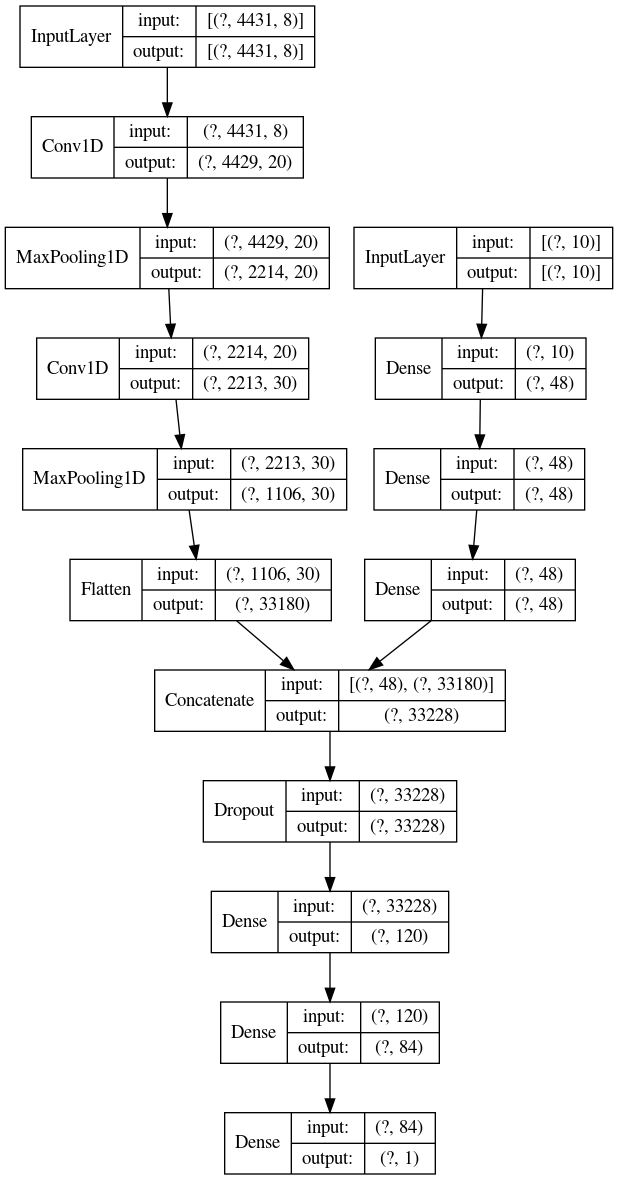

In [18]:
#Model conditions
num_epochs=50000
patience=int(num_epochs/5)
batch_size=20#validation data size

callbacks_list=[EarlyStopping(monitor='val_loss', patience=patience),
                ModelCheckpoint(os.path.join(saving_dir,'model_cnn.h5'),
                                save_best_only=True)]#,
#                TensorBoard(log_dir=os.path.join(main_dir,'results','logs'),
#                            histogram_freq=1)]
#Plot model
plot_model(model,to_file=os.path.join(saving_dir,'network_model_cnn.png'),
           show_shapes = True,show_layer_names = False)

In [19]:
#Training the model
kf= KFold(n_splits=10,shuffle=True,random_state=42)
mmsc=MinMaxScaler()

y_train=[]
y_val=[]
train_pred=[]
val_pred=[]
mse_train_results=[]
mse_val_results=[]
me_train_results=[]
me_val_results=[]
r2_train_results=[]
r2_val_results=[]
all_history=[]

i=1

init_time=datetime.datetime.now()
print('Model starts training at:',init_time) 

for train, val in kf.split(X_seq,y): 
    
    print('\nTraining fold: ',i)
    
    y_train.append(y[train])
    y_val.append(y[val])
    
    X_train_tab=mmsc.fit_transform(X_tab[train])
    X_val_tab=mmsc.transform(X_tab[val])
    
    X_train_seq=X_seq[train]
    X_val_seq=X_seq[val]
    
    #min max scaler applied to all seq samples as a joint
    X_tr_sq_ur=np.reshape(X_train_seq,(X_train_seq.shape[0]*X_train_seq.shape[1],
                                        X_train_seq.shape[2]))
    
    X_vl_sq_ur=np.reshape(X_val_seq,(X_val_seq.shape[0]*X_val_seq.shape[1],
                                        X_val_seq.shape[2]))
    
    X_tr_sq=mmsc.fit_transform(X_tr_sq_ur)
    X_vl_sq=mmsc.transform(X_vl_sq_ur)
    
    X_train_seq=np.reshape(X_tr_sq,(X_train_seq.shape[0],X_train_seq.shape[1],
                                        X_train_seq.shape[2]))
    
    X_val_seq=np.reshape(X_vl_sq,(X_val_seq.shape[0],X_val_seq.shape[1],
                                        X_val_seq.shape[2]))
    
    
    history=model.fit({'tabular':X_train_tab,'sequential':X_train_seq},y[train],
                      epochs=num_epochs,batch_size=batch_size,verbose=1,
                      validation_data=(
                          {'tabular':X_val_tab,'sequential':X_val_seq},
                          y[val]),callbacks=callbacks_list)
    all_history.append(history)
    
    y_train_pred=model.predict({'tabular':X_train_tab,'sequential':X_train_seq})
    y_val_pred=model.predict({'tabular':X_val_tab,'sequential':X_val_seq})
    train_pred.append(y_train_pred)
    val_pred.append(y_val_pred)
    
    mse_train=mean_squared_error(y[train],y_train_pred)
    mse_val=mean_squared_error(y[val],y_val_pred)
    mse_train_results.append(mse_train)
    mse_val_results.append(mse_val)
    
    me_train=mean_absolute_error(y[train],y_train_pred)
    me_val=mean_absolute_error(y[val],y_val_pred)
    me_train_results.append(me_train)
    me_val_results.append(me_val)
    
    r2_train=r2_score(y[train],y_train_pred)
    r2_val=r2_score(y[val],y_val_pred)
    r2_train_results.append(r2_train)
    r2_val_results.append(r2_val)
    
    i+=1

end_time=datetime.datetime.now()
print('Model finishes training at:',end_time)

total_time=end_time-init_time
print('Total duration of model training:',total_time)

print("\nTraining finished correctly!\n")

Model starts training at: 2020-08-22 15:11:46.541464

Training fold:  1
Train on 180 samples, validate on 20 samples
Epoch 1/50
180/180 [==============================] - 0s 1ms/sample - loss: 18.8197 - mae: 12.0425 - mse: 450.4574 - val_loss: 24.5574 - val_mae: 17.7809 - val_mse: 1043.1405
Epoch 2/50
180/180 [==============================] - 1s 7ms/sample - loss: 18.8051 - mae: 12.0292 - mse: 449.0598 - val_loss: 24.5191 - val_mae: 17.7438 - val_mse: 1039.9558
Epoch 3/50
180/180 [==============================] - 1s 5ms/sample - loss: 18.8081 - mae: 12.0334 - mse: 447.5332 - val_loss: 24.4807 - val_mae: 17.7066 - val_mse: 1036.7859
Epoch 4/50
180/180 [==============================] - 0s 2ms/sample - loss: 18.7715 - mae: 11.9981 - mse: 445.2393 - val_loss: 24.4418 - val_mae: 17.6690 - val_mse: 1033.5594
Epoch 5/50
180/180 [==============================] - 1s 5ms/sample - loss: 18.7537 - mae: 11.9815 - mse: 442.9779 - val_loss: 24.4042 - val_mae: 17.6327 - val_mse: 1030.4639
Epoch 6/

180/180 [==============================] - 1s 8ms/sample - loss: 18.2831 - mae: 11.5667 - mse: 392.5258 - val_loss: 23.4229 - val_mae: 16.7073 - val_mse: 939.4918
Epoch 48/50
180/180 [==============================] - 1s 4ms/sample - loss: 18.2662 - mae: 11.5512 - mse: 391.4248 - val_loss: 23.4080 - val_mae: 16.6938 - val_mse: 937.9250
Epoch 49/50
180/180 [==============================] - 1s 8ms/sample - loss: 18.2671 - mae: 11.5535 - mse: 390.3572 - val_loss: 23.3927 - val_mae: 16.6799 - val_mse: 936.3368
Epoch 50/50
180/180 [==============================] - 1s 6ms/sample - loss: 18.2665 - mae: 11.5543 - mse: 390.8172 - val_loss: 23.3780 - val_mae: 16.6665 - val_mse: 934.7957

Training fold:  2
Train on 180 samples, validate on 20 samples
Epoch 1/50
180/180 [==============================] - 0s 1ms/sample - loss: 18.5108 - mae: 11.8000 - mse: 431.4762 - val_loss: 21.2208 - val_mae: 14.5107 - val_mse: 558.6077
Epoch 2/50
180/180 [==============================] - 1s 4ms/sample - loss

180/180 [==============================] - 2s 12ms/sample - loss: 18.3069 - mae: 11.6569 - mse: 410.8425 - val_loss: 20.8429 - val_mae: 14.1937 - val_mse: 523.9472
Epoch 44/50
180/180 [==============================] - 1s 7ms/sample - loss: 18.2957 - mae: 11.6471 - mse: 410.2088 - val_loss: 20.8386 - val_mae: 14.1909 - val_mse: 523.7244
Epoch 45/50
180/180 [==============================] - 1s 3ms/sample - loss: 18.2943 - mae: 11.6472 - mse: 410.4081 - val_loss: 20.8328 - val_mae: 14.1866 - val_mse: 523.2436
Epoch 46/50
180/180 [==============================] - 0s 2ms/sample - loss: 18.2836 - mae: 11.6381 - mse: 409.4388 - val_loss: 20.8278 - val_mae: 14.1831 - val_mse: 523.0002
Epoch 47/50
180/180 [==============================] - 1s 4ms/sample - loss: 18.2822 - mae: 11.6382 - mse: 409.8861 - val_loss: 20.8217 - val_mae: 14.1785 - val_mse: 522.5927
Epoch 48/50
180/180 [==============================] - 1s 5ms/sample - loss: 18.2467 - mae: 11.6041 - mse: 408.4717 - val_loss: 20.8166 

Epoch 40/50
180/180 [==============================] - 0s 961us/sample - loss: 18.6889 - mae: 12.1109 - mse: 437.9103 - val_loss: 15.8631 - val_mae: 9.2859 - val_mse: 174.3445
Epoch 41/50
180/180 [==============================] - 1s 6ms/sample - loss: 18.6545 - mae: 12.0780 - mse: 438.9668 - val_loss: 15.8614 - val_mae: 9.2858 - val_mse: 174.3142
Epoch 42/50
180/180 [==============================] - 2s 13ms/sample - loss: 18.6687 - mae: 12.0938 - mse: 437.9215 - val_loss: 15.8595 - val_mae: 9.2855 - val_mse: 174.2972
Epoch 43/50
180/180 [==============================] - 3s 17ms/sample - loss: 18.6972 - mae: 12.1239 - mse: 440.1200 - val_loss: 15.8582 - val_mae: 9.2857 - val_mse: 174.2314
Epoch 44/50
180/180 [==============================] - 1s 7ms/sample - loss: 18.6851 - mae: 12.1134 - mse: 439.0007 - val_loss: 15.8566 - val_mae: 9.2858 - val_mse: 174.2072
Epoch 45/50
180/180 [==============================] - 0s 3ms/sample - loss: 18.6467 - mae: 12.0766 - mse: 437.1016 - val_loss

Epoch 37/50
180/180 [==============================] - 1s 4ms/sample - loss: 18.6634 - mae: 12.1608 - mse: 432.4460 - val_loss: 14.5744 - val_mae: 8.0728 - val_mse: 166.1704
Epoch 38/50
180/180 [==============================] - 1s 7ms/sample - loss: 18.6509 - mae: 12.1499 - mse: 432.0271 - val_loss: 14.5709 - val_mae: 8.0709 - val_mse: 166.1500
Epoch 39/50
180/180 [==============================] - 1s 4ms/sample - loss: 18.6461 - mae: 12.1468 - mse: 432.1833 - val_loss: 14.5689 - val_mae: 8.0705 - val_mse: 166.0872
Epoch 40/50
180/180 [==============================] - 1s 6ms/sample - loss: 18.6494 - mae: 12.1517 - mse: 432.6847 - val_loss: 14.5683 - val_mae: 8.0716 - val_mse: 166.0179
Epoch 41/50
180/180 [==============================] - 0s 3ms/sample - loss: 18.6650 - mae: 12.1690 - mse: 432.2188 - val_loss: 14.5654 - val_mae: 8.0703 - val_mse: 165.9979
Epoch 42/50
180/180 [==============================] - 1s 5ms/sample - loss: 18.6488 - mae: 12.1544 - mse: 430.9621 - val_loss: 14

180/180 [==============================] - 0s 571us/sample - loss: 17.9601 - mae: 11.5346 - mse: 409.3104 - val_loss: 19.4679 - val_mae: 13.0434 - val_mse: 365.1473
Epoch 34/50
180/180 [==============================] - 0s 546us/sample - loss: 17.9495 - mae: 11.5257 - mse: 409.3093 - val_loss: 19.4660 - val_mae: 13.0432 - val_mse: 365.1028
Epoch 35/50
180/180 [==============================] - 0s 542us/sample - loss: 17.9400 - mae: 11.5179 - mse: 409.3084 - val_loss: 19.4646 - val_mae: 13.0434 - val_mse: 365.1062
Epoch 36/50
180/180 [==============================] - 0s 539us/sample - loss: 17.9608 - mae: 11.5404 - mse: 408.2351 - val_loss: 19.4634 - val_mae: 13.0440 - val_mse: 365.1618
Epoch 37/50
180/180 [==============================] - 0s 549us/sample - loss: 17.9235 - mae: 11.5048 - mse: 408.3242 - val_loss: 19.4614 - val_mae: 13.0437 - val_mse: 365.1069
Epoch 38/50
180/180 [==============================] - 0s 563us/sample - loss: 17.9389 - mae: 11.5220 - mse: 407.7748 - val_los

180/180 [==============================] - 0s 559us/sample - loss: 17.4265 - mae: 11.0789 - mse: 369.6362 - val_loss: 22.6186 - val_mae: 16.2719 - val_mse: 636.3468
Epoch 7/50
180/180 [==============================] - 0s 547us/sample - loss: 17.4100 - mae: 11.0641 - mse: 369.7675 - val_loss: 22.6195 - val_mae: 16.2745 - val_mse: 636.4600
Epoch 8/50
180/180 [==============================] - 0s 555us/sample - loss: 17.3926 - mae: 11.0485 - mse: 368.9166 - val_loss: 22.6201 - val_mae: 16.2769 - val_mse: 636.5184
Epoch 9/50
180/180 [==============================] - 0s 564us/sample - loss: 17.4261 - mae: 11.0837 - mse: 370.1688 - val_loss: 22.6205 - val_mae: 16.2790 - val_mse: 636.5558
Epoch 10/50
180/180 [==============================] - 0s 533us/sample - loss: 17.4001 - mae: 11.0595 - mse: 369.7534 - val_loss: 22.6209 - val_mae: 16.2812 - val_mse: 636.6335
Epoch 11/50
180/180 [==============================] - 0s 547us/sample - loss: 17.3876 - mae: 11.0487 - mse: 369.9221 - val_loss: 

180/180 [==============================] - 0s 560us/sample - loss: 17.5278 - mae: 11.2622 - mse: 362.5742 - val_loss: 20.0207 - val_mae: 13.7560 - val_mse: 709.4446
Epoch 42/50
180/180 [==============================] - 0s 548us/sample - loss: 17.5223 - mae: 11.2585 - mse: 362.0634 - val_loss: 20.0170 - val_mae: 13.7542 - val_mse: 709.4456
Epoch 43/50
180/180 [==============================] - 0s 553us/sample - loss: 17.5501 - mae: 11.2880 - mse: 362.4091 - val_loss: 20.0136 - val_mae: 13.7525 - val_mse: 709.5331
Epoch 44/50
180/180 [==============================] - 0s 555us/sample - loss: 17.4949 - mae: 11.2347 - mse: 360.8217 - val_loss: 20.0090 - val_mae: 13.7498 - val_mse: 709.0959
Epoch 45/50
180/180 [==============================] - 0s 553us/sample - loss: 17.5420 - mae: 11.2836 - mse: 362.7440 - val_loss: 20.0056 - val_mae: 13.7481 - val_mse: 709.1632
Epoch 46/50
180/180 [==============================] - 0s 550us/sample - loss: 17.4938 - mae: 11.2371 - mse: 360.4942 - val_los

The model has been trained only for a few epochs, so the results are not the ones achived in the presented work, but the goal of showing the process is accomplished.

In [20]:
print('Results:')
for i in range(len(mse_train_results)):
    print('\nK-fold: ',i+1)
    print('MSE train: {0:.3f}   MSE validation: {1:.3f}'.format(mse_train_results[i],
          mse_val_results[i]))
    print('MAE train: {0:.3f}   MAE validation: {1:.3f}'.format(me_train_results[i],
          me_val_results[i]))
    print('r^2 train: {0:.3f}   r^2 validation: {1:.3f}'.format(r2_train_results[i],
          r2_val_results[i]))

mse_avg_train=mean_squared_error(np.concatenate(y_train),np.concatenate(train_pred)[:,0])
mae_avg_train=mean_absolute_error(np.concatenate(y_train),np.concatenate(train_pred)[:,0])
r2_avg_train=r2_score(np.concatenate(y_train),np.concatenate(train_pred)[:,0])

mse_avg_val=mean_squared_error(np.concatenate(y_val),np.concatenate(val_pred)[:,0])
mae_avg_val=mean_absolute_error(np.concatenate(y_val),np.concatenate(val_pred)[:,0])
r2_avg_val=r2_score(np.concatenate(y_val),np.concatenate(val_pred)[:,0])

print('\n Values over the entire dataset:')    
print('MSE train: {0:.3f}   MSE validation: {1:.3f}'.format(mse_avg_train,mse_avg_val))
print('MAE train: {0:.3f}   MAE validation: {1:.3f}'.format(mae_avg_train,mae_avg_val))
print('r^2 train: {0:.3f}   r^2 validation: {1:.3f}'.format(r2_avg_train,r2_avg_val))

Results:

K-fold:  1
MSE train: 388.514   MSE validation: 934.796
MAE train: 11.540   MAE validation: 16.667
r^2 train: -0.019   r^2 validation: -0.130

K-fold:  2
MSE train: 408.247   MSE validation: 521.999
MAE train: 11.633   MAE validation: 14.169
r^2 train: 0.027   r^2 validation: -0.034

K-fold:  3
MSE train: 436.052   MSE validation: 174.151
MAE train: 12.086   MAE validation: 9.285
r^2 train: 0.040   r^2 validation: 0.053

K-fold:  4
MSE train: 428.338   MSE validation: 165.636
MAE train: 12.129   MAE validation: 8.066
r^2 train: 0.057   r^2 validation: 0.085

K-fold:  5
MSE train: 406.182   MSE validation: 365.230
MAE train: 11.471   MAE validation: 13.046
r^2 train: 0.062   r^2 validation: 0.087

K-fold:  6
MSE train: 438.686   MSE validation: 41.584
MAE train: 12.357   MAE validation: 4.870
r^2 train: 0.053   r^2 validation: 0.154

K-fold:  7
MSE train: 414.480   MSE validation: 224.618
MAE train: 11.717   MAE validation: 10.441
r^2 train: 0.069   r^2 validation: 0.177

K-fo

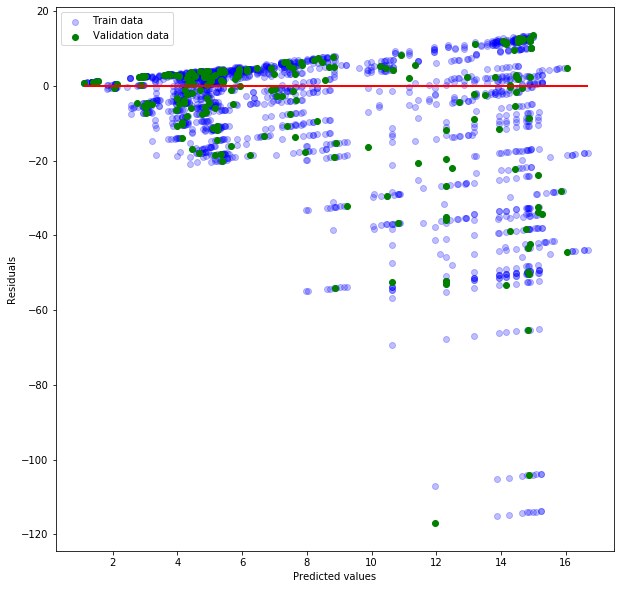

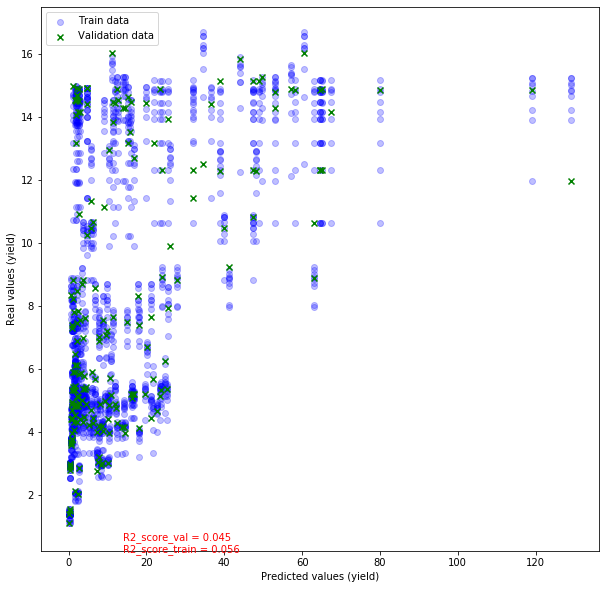

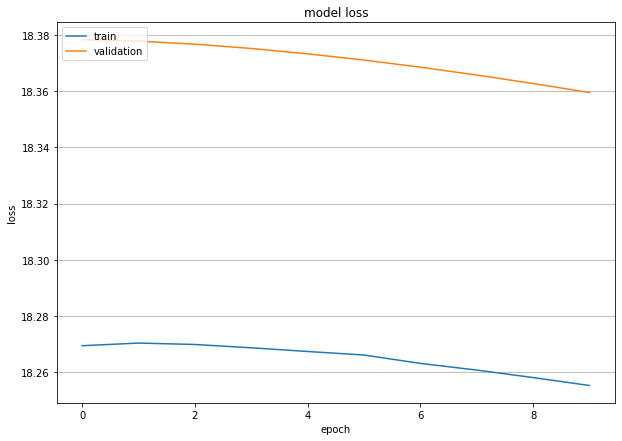

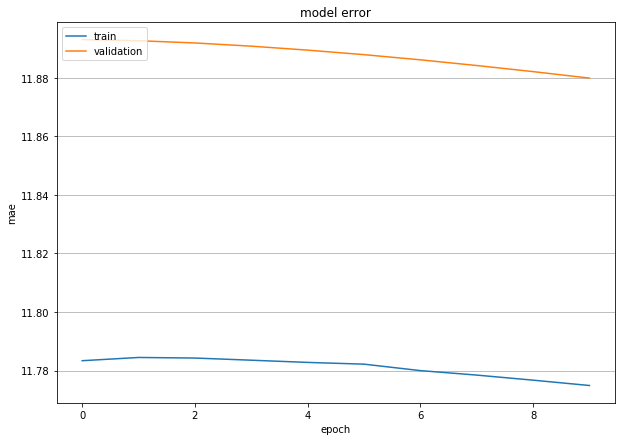

In [21]:
#Results as plots
residual_plot(np.concatenate(y_train),np.concatenate(train_pred)[:,0],
              np.concatenate(y_val),np.concatenate(val_pred)[:,0],saving_dir)

plot_regression(np.concatenate(y_train),np.concatenate(train_pred)[:,0],
              np.concatenate(y_val),np.concatenate(val_pred)[:,0],saving_dir)

plot_average_losses(all_history,saving_dir, bias=int(patience/10))

The training and validation losses tend to decrease for this example, and it is also the case for the real scenario.

In [22]:
#Writing to CSV
file_summary=os.path.join(saving_dir,'results_summary_cnn.csv')

with open(file_summary, 'w', newline='') as csvfile:
    results = csv.writer(csvfile, delimiter=',')
    results.writerow(['Values over the entire dataset (metrics):'])
    results.writerow(['MSE train:'])
    results.writerow([mse_avg_train])
    results.writerow(['MSE validation:'])
    results.writerow([mse_avg_val])
    results.writerow(['MAE train:'])
    results.writerow([mae_avg_train])
    results.writerow(['MAE validation:'])
    results.writerow([mae_avg_val])
    results.writerow(['r^2 train:'])
    results.writerow([r2_avg_train])
    results.writerow(['r^2 validation:'])
    results.writerow([r2_avg_val])
    results.writerow(['Total training time:'])
    results.writerow([total_time])

print("\nResults generated correctly!\n")
print("\nJob finished! =) \n")


Results generated correctly!


Job finished! =) 

